# In the Name of God

# Imports:

In [1]:
import math
import pandas as pd
import numpy as np
import hazm
import matplotlib.pyplot as plt
import itertools

# Defines:

In [2]:
IGNORE_CASES = ["گزارش", "ایسنا"]
MIN_FREQ_IN_TRAIN_DATA = 1
BIGRAM_WEIGHT = 10
INITIAL_SCORE = 2000

# Lemmatization vs Stemming:

In [3]:
stemmer = hazm.Stemmer()
print(stemmer.stem("می‌رفتم"))
lemmatizer = hazm.Lemmatizer()
print(lemmatizer.lemmatize("می‌رفتم").split("#")[0])

می‌رف
رفت


# Phase 1:

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data
# train_data["content"][3]
i = 0
for index, row in train_data.iterrows():
    i += 1
    print(index)
    print(row)
    if i == 20:
        break

0
label                                                 فناوری
content    گزارش های منتشر شده حاکی از آن است که کاربران ...
Name: 0, dtype: object
1
label                                                  ورزشی
content    سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
Name: 1, dtype: object
2
label                                                  حوادث
content    مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
Name: 2, dtype: object
3
label                                                 فناوری
content    یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
Name: 3, dtype: object
4
label                                                  سلامت
content    دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
Name: 4, dtype: object
5
label                                                  سلامت
content    مصرف میوه، یکی از راه های سالم برای کاهش وزن س...
Name: 5, dtype: object
6
label                                                  سیاسی
content    رئیس جمهوری پیش‌بینی، پیشگیری و درمان آسیب‌ه

In [5]:

class Parser:
    def __init__(self) -> None:
        self.normalizer = hazm.Normalizer()
        self.lemmatizer = hazm.Lemmatizer()
        self.tokenize = hazm.word_tokenize
        self.stop_words = hazm.stopwords_list()
        self.stop_words = self.stop_words + IGNORE_CASES

    def parse(self, text : str):
        tokens = self.tokenize(self.normalizer.normalize(text))
        tokens = [elem for elem in tokens if elem not in self.stop_words and elem.isalpha()]
        tokens = [self.lemmatize(elem) for elem in tokens if elem not in self.stop_words]
        return tokens

    def unigram_parse(self, text : str):
        tokens = self.parse(text)
        return tokens    

    def bigram_parse(self, text : str):
        tokens = self.parse(text)
        bigram_tokens = []
        for i in range(len(tokens) - 1):
            bigram_tokens.append(tokens[i] + " " + tokens[i + 1])
        return bigram_tokens

    def lemmatize(self, word :str) -> str:
        return self.lemmatizer.lemmatize(word).split('#')[0]

p = Parser()
tokens = p.bigram_parse(train_data["content"][3])
print(tokens)
        

['نوجوان انگلیسی', 'انگلیسی اتهام', 'اتهام هک', 'هک کاربر', 'کاربر ایمیل', 'ایمیل ارشد', 'ارشد آمریکایی', 'آمریکایی سال', 'سال حبس', 'حبس دارالتادیب', 'دارالتادیب محکوم', 'محکوم نقل', 'نقل خبرگزاری', 'خبرگزاری آسوشیتدپرس', 'آسوشیتدپرس نوجوان', 'نوجوان نام', 'نام کین', 'کین گمبل', 'گمبل بازه', 'بازه زمان', 'زمان اقدام', 'اقدام هک', 'هک دسترس', 'دسترس اطلاعات', 'اطلاعات کاربر', 'کاربر مارک', 'مارک جیلیانو', 'جیلیانو مدیر', 'مدیر وقت', 'وقت اف', 'اف آی', 'آی جی', 'جی جانسون', 'جانسون وزیر', 'وزیر وقت', 'وقت کشور', 'کشور جان', 'جان برن', 'برن رئیس', 'رئیس وقت', 'وقت سیا', 'سیا گمبل', 'گمبل عضو', 'عضو گروه', 'گروه هکری', 'هکری موسوم', 'موسوم Crackas', 'Crackas With', 'With Attitude', 'Attitude اطلاعات', 'اطلاعات صورت', 'صورت آنلاین', 'آنلاین منتشر', 'منتشر گمبل', 'گمبل سال', 'سال گذشته', 'گذشته میلاد', 'میلاد گناهکار', 'گناهکار نوجوان', 'نوجوان انگلیسی', 'انگلیسی روز', 'روز جمعه', 'جمعه دادگاه', 'دادگاه کیفر', 'کیفر لندن', 'لندن سال', 'سال حبس', 'حبس دارالتادیب', 'دارالتادیب محکوم', 'محکوم 

In [6]:
class Topic:
    def __init__(self, name) -> None:
        self.name = name
        self.words = {}
        self.N = 0
        self.sorted = False


    def sort_words(self):
        if self.sorted:
            return
        self.words = {k: v for k, v in sorted(self.words.items(), key=lambda item: item[1], reverse=True) if v >= MIN_FREQ_IN_TRAIN_DATA}
        for count in self.words.values():
            self.N += count
        self.sorted = True
    
    def add(self, tokens, alpha = 1):
        for t in tokens:
            if t in self.words:
                self.words[t] += alpha
            else:
                self.words.update({t: alpha})

    def plot(self, n :int):
        self.sort_words()
        result = dict(itertools.islice(self.words.items(), n))
        plt.bar(result.keys(), result.values())
        plt.xlabel(self.name)
        plt.ylabel('frequency')
        plt.show()    

    def cal_score(self, content):
        self.sort_words()
        score = INITIAL_SCORE
        minimum_score = math.log2(1/ self.N)
        for w in content:
            if w in self.words:
                score += math.log2(self.words[w]/ self.N)
            else:
                score += minimum_score
        return score

topics = {}

def train():
    for index, row in train_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)

        if label not in topics:
            topics.update({label: Topic(label)})

        topics[label].add(unigram_content)    
        topics[label].add(bigram_content, BIGRAM_WEIGHT)    

train()

In [7]:
# math.log2(1/1024)

# x = {"1" : 1 ,
#     "b" : 2
# }

# "b" in x

# Pase 2:

In [8]:
def predict_category(content):
    max_score = -math.inf
    chosen_topic = ""
    for t in topics:
        if(topics[t].cal_score(content) > max_score):
            max_score = topics[t].cal_score(content)
            chosen_topic = t
    return chosen_topic

In [9]:
def predict():
    x = []
    for index, row in test_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)
        predicted_label = predict_category(unigram_content + bigram_content)
        x.append(predicted_label)
    return x

In [10]:

x = predict()
wrong_predict = 0
for i in range(len(x)):
    # print(f"{x[i]},,{test_data['label'][i]}")
    if x[i] != test_data['label'][i]:
        wrong_predict += 1

print(wrong_predict)


58


In [11]:
# test_data[["label","predicted_label"]].to_csv("prediction.txt")

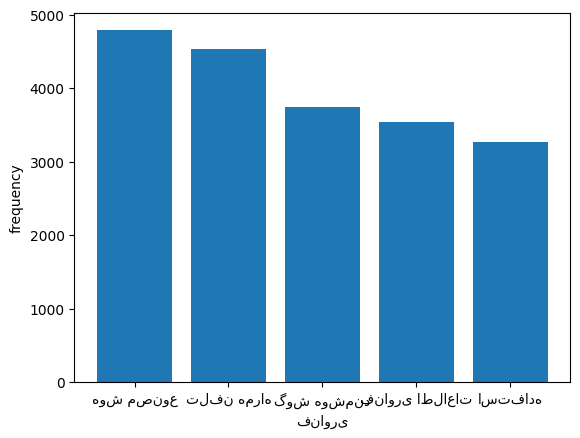

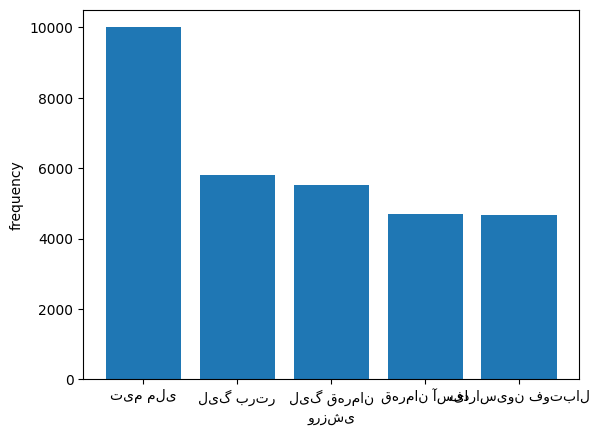

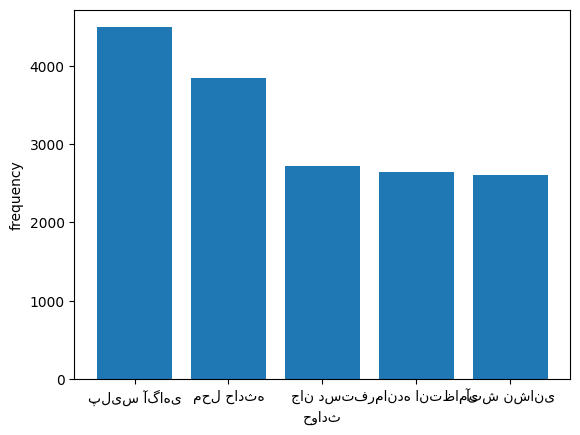

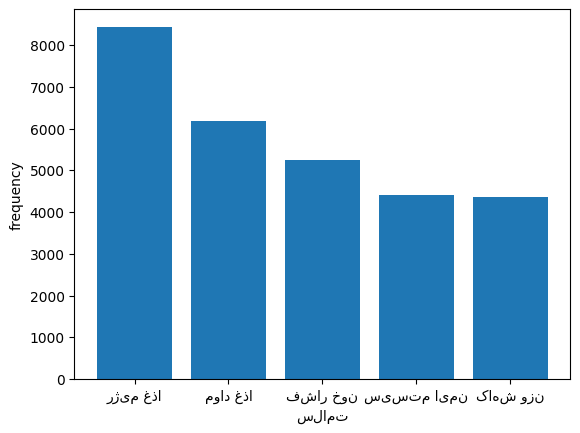

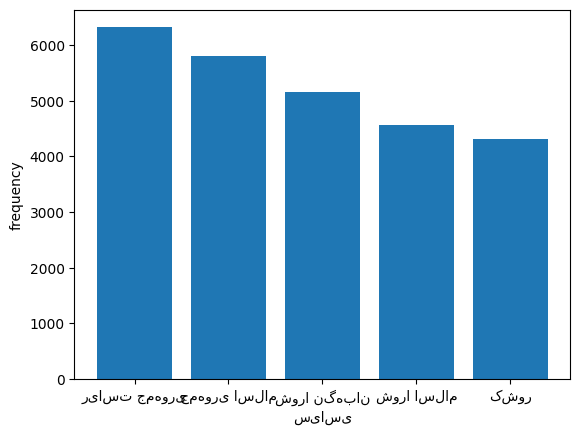

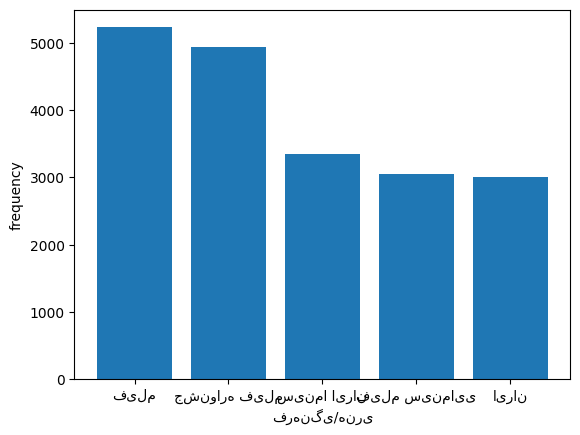

In [12]:
for topic in topics.values():
    topic.plot(5)

In [13]:
x = topics["سیاسی"].words
len(x)
print(x)

{'ریاست جمهوری': 6320, 'جمهوری اسلام': 5810, 'شورا نگهبان': 5150, 'شورا اسلام': 4560, 'کشور': 4308, 'مجلس شورا': 4290, 'رئیس جمهور': 4020, 'امور خارجه': 3560, 'انتخابات ریاست': 3550, 'اسلام ایران': 3320, 'ایران': 3305, 'انقلاب اسلام': 2980, 'قانون اساس': 2900, 'قوه قضاییه': 2870, 'مردم': 2847, 'دولت': 2338, 'رییس جمهور': 2230, 'مقام معظم': 2220, 'معظم رهبر': 2200, 'مجلس': 2071, 'اسلام': 1987, 'اصلاح طلب': 1920, 'امنیت ملی': 1900, 'شورا': 1857, 'انتخابات': 1853, 'مجمع تشخیص': 1830, 'ثبت نام': 1820, 'سردار سلیمان': 1810, 'ملت ایران': 1780, 'وزارت امور': 1780, 'آیت الله': 1760, 'شهید سلیمان': 1740, 'فضا مجاز': 1710, 'سیاست خارج': 1680, 'وزیر امور': 1670, 'حاج قاسم': 1660, 'رییس جمهوری': 1650, 'سال': 1644, 'وزارت کشور': 1630, 'اقتصاد کشور': 1590, 'کار': 1580, 'جمهوری': 1576, 'تشخیص مصلحت': 1560, 'مصلحت نظام': 1490, 'رئیس': 1480, 'رهبر انقلاب': 1470, 'بانک مرکزی': 1450, 'رئیس جمهوری': 1410, 'نیرو مسلح': 1400, 'وزیر خارجه': 1400, 'رئیس قوه': 1310, 'انقلاب': 1296, 'مجلس یازدهم': 1280, 'قانون'